In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.contrib import rnn 

# TESTING RNN (TUTORIAL)
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

# prints out full length of array
# np.set_printoptions(threshold=np.nan)

tfrecords_filename = 'D:/Documents/nsynth/nsynth-train.tfrecord'
filter_tfrecords_filename = 'D:/Documents/nsynth/filtered_data_keyboard.tfrecord'
testfile = 'D:/Documents/nsynth/nsynth-test.tfrecord'

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# parse TFRecord file into a generator (brian)
# https://github.com/faroit/nsynth-convert
def nsynth_generator(tfrecords_filename):
    for serialized_example in tf.python_io.tf_record_iterator(tfrecords_filename):
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        f = example.features.feature
        i=0
#         result = tf.train.Example.FromString(serialized_example)
#         print(result)
        data_array = []

        audio = np.array(f['audio'].float_list.value)

        data = {
            'note':
                f['note'].int64_list.value[i],
            'note_str':
                f['note_str'].bytes_list.value[i],
            'instrument':
                f['instrument'].int64_list.value[i],
            'instrument_str':
                f['instrument_str'].bytes_list.value[i],
            'pitch':
                f['pitch'].int64_list.value[i],
            'velocity':
                f['pitch'].int64_list.value[i],
            'samplerate':
                f['sample_rate'].int64_list.value[i],
            'audio':
                np.array(f['audio'].float_list.value),
            'qualities':
                np.array(f['qualities'].int64_list.value),
            'qualities_str':
                np.array(f['qualities_str'].int64_list.value),
            'instrument_family':
                f['instrument_family'].int64_list.value[i],
            'instrument_family_str':
                f['instrument_family_str'].bytes_list.value[i],
            'instrument_source':
                f['instrument_family'].int64_list.value[i],
            'instrument_source_str':
                f['instrument_source_str'].bytes_list.value[i],
        }
#         print(data)

        yield example.SerializeToString(), f, data, audio

In [2]:
# parse TFRecord file into a generator (bryan)
# https://github.com/faroit/nsynth-convert
def nsynth_generator(tfrecords_filename):
    for serialized_example in tf.python_io.tf_record_iterator(tfrecords_filename):
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        f = example.features.feature
#         result = tf.train.Example.FromString(serialized_example)
#         print(result)

        audio = np.array(f['audio'].float_list.value)

        data = {
            'note':
                f['note'].int64_list.value[0],
            'note_str':
                f['note_str'].bytes_list.value[0],
            'instrument':
                f['instrument'].int64_list.value[0],
            'instrument_str':
                f['instrument_str'].bytes_list.value[0],
            'pitch':
                f['pitch'].int64_list.value[0],
            'velocity':
                f['pitch'].int64_list.value[0],
            'sample_rate':
                f['sample_rate'].int64_list.value[0],
            'audio':
                np.array(f['audio'].float_list.value),
            'qualities':
                np.array(f['qualities'].int64_list.value),
            'qualities_str':
                np.array(f['qualities_str'].bytes_list.value),
            'instrument_family':
                f['instrument_family'].int64_list.value[0],
            'instrument_family_str':
                f['instrument_family_str'].bytes_list.value[0],
            'instrument_source':
                f['instrument_family'].int64_list.value[0],
            'instrument_source_str':
                f['instrument_source_str'].bytes_list.value[0],
        }
#         print(data)

        yield data, audio

In [ ]:
# Filter function to only contain keyboard tag
def filterData(inputFile, outputFile):
    dataset = nsynth_generator(inputFile)
    count = 1
    data = next(dataset)
    writer = tf.python_io.TFRecordWriter(outputFile)
    try:
        while data:
            if data[1]["instrument_family"].int64_list.value[0] == 4:
                writer.write(data[0])
            print(data[2])
            data = next(dataset)
    except StopIteration:
        pass
    writer.close()

In [ ]:
# Testing nsynth_generator function
gen_samples = nsynth_generator(tfrecords_filename)
metadata, audio = next(gen_samples)

In [ ]:
# Filters the 80GB of data to new file total: 51820
outputFile = "filtered_data_keyboard2.tfrecord"
filterData(tfrecords_filename, outputFile)

In [ ]:
# Print out all data
# for example in tf.python_io.tf_record_iterator(tfrecords_filename):
for example in tf.python_io.tf_record_iterator(filter_tfrecords_filename):
    result = tf.train.Example.FromString(example)
    print(result)

In [ ]:
gen_filter = nsynth_generator(filter_tfrecords_filename)

In [ ]:
# Filtered data
# metadata, audio = next(gen_filter)
for i in range(5):
    metadata, audio = next(gen_filter)
print(audio)
plt.figure(figsize=(14, 5))
plt.plot(audio)
Audio(audio, rate=metadata['sample_rate'])

In [ ]:
# print(len(audio))
# print(len(metadata['audio']))
CQT = librosa.amplitude_to_db(librosa.magphase(librosa.cqt(audio, sr=16000))[0], ref=np.max)
# plt.figure(figsize=(14, 5))
# print(CQT)
librosa.display.specshow(CQT, sr=metadata['sample_rate'], x_axis='time', y_axis='hz')
# print(audio)
S = np.abs(librosa.stft(audio))
# print(librosa.stft(audio))
# print(S)
comps, acts = librosa.decompose.decompose(S)
print(len(comps))
print(len(comps[0]))
print(len(acts))
print(len(acts[0]))
# print(comps)
# print(acts)

In [8]:
# RNN code
# source: https://pythonprogramming.net/rnn-tensorflow-python-machine-learning-tutorial/
hm_epochs = 3
n_classes = 8
batch_size = 1025

# chunk_size = 25
# n_chunks = 41
chunk_size = 4
n_chunks = 2
rnn_size = 128

# hm_epochs = 3
# n_classes = 10
# batch_size = 128
# chunk_size = 28
# n_chunks = 28
# rnn_size = 128

In [5]:
x = tf.placeholder('float', [None, n_chunks, chunk_size])
y = tf.placeholder('float', [None,None])
print(x.get_shape())

(?, 2, 4)


In [6]:
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, 8])
    x = tf.split(x, n_chunks, 0)
    print(x)
    lstm_cell = rnn.BasicLSTMCell(rnn_size,state_is_tuple=True) 
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases']

    return output

In [ ]:
# REFERENCE CODE (dont run this code)
def train_neural_network(x):
#     tf.reset_default_graph()
    prediction = recurrent_neural_network(x)
    # OLD VERSION:
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    # NEW:
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    

    with tf.Session() as sess:
        # OLD:
        #sess.run(tf.initialize_all_variables())
        # NEW:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
#             for metadata, audio in gen_filter:
                ## need to change batch to audio
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
        sess.close()

train_neural_network(x)

In [ ]:
int(mnist.train.num_examples)

In [7]:
prediction = recurrent_neural_network(x)
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
optimizer = tf.train.AdamOptimizer().minimize(cost)
# MODIFIED CODE
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cnt = 0
    gen_filter = nsynth_generator(filter_tfrecords_filename)
    metadata, audio = next(gen_filter)

    for epoch in range(hm_epochs):
        epoch_loss = 0   
        cnt=0
#         try:
#             while metadata:
#                 if(cnt == 25): break
                
#                 X = librosa.cqt(audio)
#                 Xdb = librosa.amplitude_to_db(abs(X))
#                 print(len(X))
#                 print(len(X[0]))
#                 librosa.display.specshow(Xdb, sr=metadata['sample_rate'], x_axis='time', y_axis='hz')
                
# #                 epoch_x, epoch_y = mnist.train.next_batch(batch_size)           
# #                 epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
# #                 _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
# #                 epoch_loss += c 
                
#                 metadata, audio = next(gen_filter)
#                 cnt += 1
#         except StopIteration:
#             pass
        for metadata, audio in gen_filter:
            if(cnt == 5): break
            cnt += 1
            S = np.abs(librosa.stft(metadata['audio']))
#             comps, acts = librosa.decompose.decompose(S)
            comps, acts = librosa.decompose.decompose(S, n_components=8)
            print(len(comps), len(comps[0]))
            print(len(acts), len(acts[0]))
            comps = comps.reshape((batch_size, n_chunks, chunk_size))
            print(len(comps), len(comps[0]))
            # STUCK HERE
            _, c = sess.run([optimizer, cost], feed_dict={x: comps, y: acts})
            epoch_loss += c
        print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
        
        # Filter function to only contain keyboard tag
#             print(epoch_y)
            ## need to change batch to audio
#             epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
#             _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
#             epoch_loss += c

#         print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

#     correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

#     accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#     print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
    sess.close()


[<tf.Tensor 'split:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 8) dtype=float32>]
1025 8
8 126
1025 2


InvalidArgumentError: Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 1025) and num_split 2
	 [[Node: split = Split[T=DT_FLOAT, num_split=2, _device="/job:localhost/replica:0/task:0/device:GPU:0"](softmax_cross_entropy_with_logits/concat/axis, Reshape)]]
	 [[Node: Mean/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_424_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'split', defined at:
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\imbko\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-675461f774e8>", line 1, in <module>
    prediction = recurrent_neural_network(x)
  File "<ipython-input-6-9f36de2ddb0e>", line 6, in recurrent_neural_network
    x = tf.split(x, n_chunks, 0)
  File "C:\Users\imbko\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\array_ops.py", line 1383, in split
    axis=axis, num_split=num_or_size_splits, value=value, name=name)
  File "C:\Users\imbko\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\gen_array_ops.py", line 9143, in split
    "Split", split_dim=axis, value=value, num_split=num_split, name=name)
  File "C:\Users\imbko\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\imbko\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "C:\Users\imbko\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 1025) and num_split 2
	 [[Node: split = Split[T=DT_FLOAT, num_split=2, _device="/job:localhost/replica:0/task:0/device:GPU:0"](softmax_cross_entropy_with_logits/concat/axis, Reshape)]]
	 [[Node: Mean/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_424_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [ ]:
prediction = recurrent_neural_network(x)

In [ ]:
print(prediction)

In [ ]:
comps, acts = librosa.decompose.decompose(S, n_components=8)
print(len(comps))
print(len(comps[1]))
comps = comps.reshape((batch_size, n_chunks, chunk_size))
print(len(comps))
print(len(comps[0]))
print(len(comps[0][0]))

In [ ]:
epoch_x, epoch_y = mnist.train.next_batch(batch_size)
print(len(epoch_x))
print(len(epoch_x[0]))

In [3]:
# Filter function to only contain keyboard tag
def selectData(inputFile, outputFile):
    dataset = nsynth_generator(inputFile)
    cnt = 0
    arr_cnt = 0
    data = next(dataset)
    writer = tf.python_io.TFRecordWriter(outputFile)
    try:
        while data:
#             if (arr_cnt == 50): break
#             if ~300000 entries -> result ~60000
            if cnt == 50:
                cnt = 0
                writer.write(data[0])
                print(arr_cnt)
                print(data[2])
                arr_cnt+=1
            cnt+=1      
            data = next(dataset)
    except StopIteration:
        pass
    writer.close()

In [7]:
outputFile = "select_50_interval_data.tfrecord"
selectData(tfrecords_filename, outputFile)

0
{'note_str': b'bass_synthetic_018-101-100', 'samplerate': 16000, 'instrument_str': b'bass_synthetic_018', 'audio': array([ 1.11591794e-06, -1.13046860e-06,  1.02081606e-06, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'velocity': 101, 'instrument_family': 0, 'pitch': 101, 'qualities_str': array([], dtype=float64), 'instrument_source_str': b'synthetic', 'note': 209097, 'qualities': array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0]), 'instrument': 276, 'instrument_family_str': b'bass', 'instrument_source': 0}
1
{'note_str': b'bass_synthetic_018-102-100', 'samplerate': 16000, 'instrument_str': b'bass_synthetic_018', 'audio': array([ 1.77361608e-06, -2.75795855e-06,  3.96483347e-06, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'velocity': 102, 'instrument_family': 0, 'pitch': 102, 'qualities_str': array([], dtype=float64), 'instrument_source_str': b'synthetic', 'note': 222359, 'qualities': array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0]), 'instrument': 276, 'instrument_fa

16
{'note_str': b'bass_synthetic_018-029-100', 'samplerate': 16000, 'instrument_str': b'bass_synthetic_018', 'audio': array([-1.97130312e-08,  3.21672253e-08, -5.36097922e-08, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'velocity': 29, 'instrument_family': 0, 'pitch': 29, 'qualities_str': array([], dtype=float64), 'instrument_source_str': b'synthetic', 'note': 272275, 'qualities': array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0]), 'instrument': 276, 'instrument_family_str': b'bass', 'instrument_source': 0}
17
{'note_str': b'bass_synthetic_018-030-100', 'samplerate': 16000, 'instrument_str': b'bass_synthetic_018', 'audio': array([ 4.82763994e-07, -3.31149550e-07,  5.38172635e-08, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'velocity': 30, 'instrument_family': 0, 'pitch': 30, 'qualities_str': array([], dtype=float64), 'instrument_source_str': b'synthetic', 'note': 179478, 'qualities': array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0]), 'instrument': 276, 'instrument_fami

KeyboardInterrupt: 

In [3]:
gen_samples = nsynth_generator(testfile)
metadata, audio = next(gen_samples)

[ 6.05920877e-06 -6.37224093e-06  6.70708596e-06 ... -5.23325662e-06
  5.49129936e-06 -5.76611819e-06]


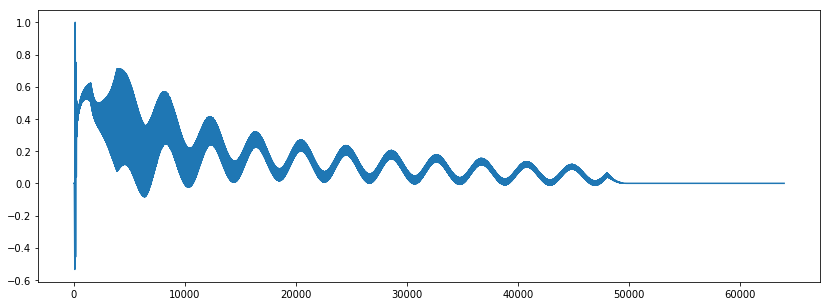

In [10]:
metadata, audio = next(gen_samples)
print(audio)
plt.figure(figsize=(14, 5))
plt.plot(audio)
Audio(audio, rate=metadata['sample_rate'])